## Swing Probability in Baseball <a id="toc1"></a>
**Author:** Danilo Arruda, PhD  



## Table of Contents <a id="toc0"></a>
- [Swing Probability in Baseball](#toc1)
- [Project and Data Description](#toc2)
  - [Data Preparation](#toc2_1)
  - [Modeling](#toc2_2)
  - [Model Calibration](#toc2_3)
  - [Model Diagnostics](#toc2_4)
  - [Predicting Swing Probability for Year 3](#toc2_5)
- [Feature Exploration](#toc3)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Project and Data Description <a id="toc2"></a>


This project aims to develop a swing probability model in basebal using historical data from three seasons of Major League Baseball (MLB) games. Also, we will explore what features are more determinant on swing probability. <br>The dataset includes detailed information about each pitch, such as speed, type, and the batter's and pitcher's characteristics.
<br><br>The project involves several steps, including data preparation, modeling, model calibration, diagnostics, and feature exploration. The final goal is to predict swing probabilities for a specific season 3. <br><br>This model might be used by teams to drive strategic decisions, such as player selection and in-game tactics.


In [3]:
#Importing relevant modules
# %reset -f
# Importing data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import shap
from pybaseball import statcast, pitching_stats_range, cache
from tqdm import tqdm  


### Data Preparation <a id="toc2_1"></a>


In [5]:
####################################### THIS MIGHT TAKE A FEW MIN TO RUN #######################################
#allowing cache
cache.enable()

#Retrieve data from API - This might take a while to load
data_2022 = statcast(start_dt='2022-04-07', end_dt='2022-10-05')
data_2023 = statcast(start_dt='2023-03-30', end_dt='2023-10-01')
data_2024 = statcast(start_dt='2024-03-28', end_dt='2024-06-29')


This is a large query, it may take a moment to complete


 84%|████████▎ | 152/182 [00:13<00:02, 13.74it/s]c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|██████████| 182/182 [00:16<00:00, 11.19it/s]
c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete


  0%|          | 0/186 [00:00<?, ?it/s]c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 1/186 [00:03<09:32,  3.09s/it]c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is depr

This is a large query, it may take a moment to complete


  0%|          | 0/94 [00:00<?, ?it/s]c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 1/94 [00:03<05:35,  3.61s/it]c:\Users\danil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprec

In [6]:
# determining the relevant variables for swing probability
vars = [
    "batter", "pitcher","description","pitch_type", "release_speed", "release_spin_rate", "spin_axis",
    "release_pos_x", "release_pos_y", "release_pos_z", "release_extension",
    "pfx_x", "pfx_z",
    "plate_x", "plate_z", "zone", "sz_top", "sz_bot",
    "balls", "strikes",
    "stand", "p_throws",
    "outs_when_up", "inning", "inning_topbot",
    "bat_score", "fld_score"
]

#Concatenating year 1 and 2 into training dataset
df_training = pd.concat([data_2022[vars], data_2023[vars]], ignore_index=True)

In [7]:
#Quick check of the dataset and nans
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1426485 entries, 0 to 1426484
Data columns (total 27 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   batter             1426485 non-null  Int64  
 1   pitcher            1426485 non-null  Int64  
 2   description        1426485 non-null  object 
 3   pitch_type         1425829 non-null  object 
 4   release_speed      1425788 non-null  Float64
 5   release_spin_rate  1419890 non-null  Int64  
 6   spin_axis          1419852 non-null  Int64  
 7   release_pos_x      1425789 non-null  Float64
 8   release_pos_y      1425789 non-null  Float64
 9   release_pos_z      1425789 non-null  Float64
 10  release_extension  1423772 non-null  Float64
 11  pfx_x              1425778 non-null  Float64
 12  pfx_z              1425788 non-null  Float64
 13  plate_x            1425789 non-null  Float64
 14  plate_z            1425789 non-null  Float64
 15  zone               1425789 non-n

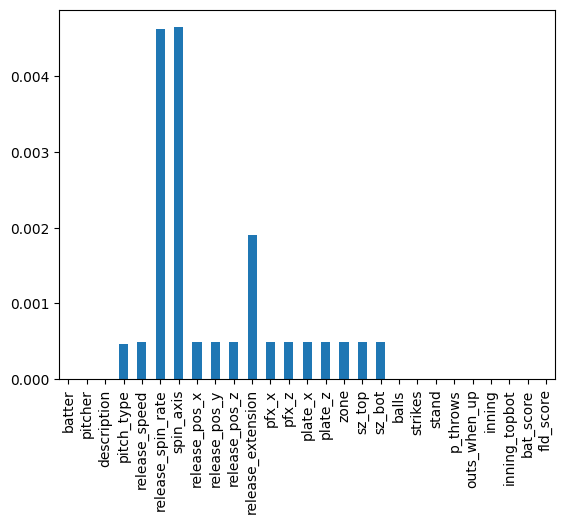

In [8]:
# Calculate the percentage of NaNs in each column
nan_proportion = (df_training.isna().sum() / len(df_training))

# Plot the percentage of NaNs
nan_proportion.plot.bar()

# Since the amount of nans is small we can drop them
df_training = df_training.dropna()


Since I am interested in swing probability, regardless of the outcome. I will drop the description column and will create another indicating whether the player swung the ball or not.

['hit_into_play' 'swinging_strike' 'ball' 'called_strike' 'foul'
 'foul_bunt' 'blocked_ball' 'swinging_strike_blocked' 'hit_by_pitch'
 'foul_tip' 'missed_bunt' 'pitchout' 'bunt_foul_tip']


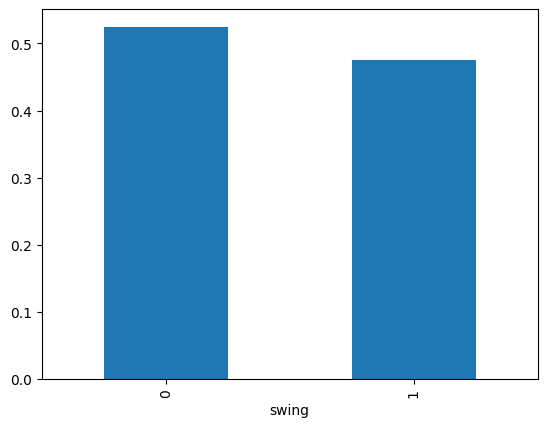

In [9]:
#Checking the descriptions of the data to determine the swings
print(df_training['description'].unique())

#Determining the descriptions that are swings
swing = ["foul", "hit_into_play", "swinging_strike", "foul_tip",
                  "swinging_strike_blocked", "foul_pitchout"]

#Add a swing column based on the description
df_training['swing'] = np.where(df_training['description'].isin(swing), 1, 0)
data_2024['swing'] = np.where(data_2024['description'].isin(swing), 1, 0)
#ploting the percentage of swings that are classified as 1 and 0
swing_proportion = (df_training['swing'].value_counts() / len(df_training))
swing_proportion.plot.bar()

#Dropping the description column
df_training = df_training.drop(columns=['description'])

Finally, since some columns include qualitative data, I will convert them into dummies so we can better analyze the dataset using machine learning.

In [10]:
#Transforming the string variables into numeric by creating dummies
#Extracting the string columns
string_cols = df_training.select_dtypes(include=["object", "string"]).columns
print(string_cols)
#Making the dummies
df_training = pd.get_dummies(df_training, columns=string_cols)

# storing colnames 
trained_columns = df_training.columns.tolist()

Index(['pitch_type', 'stand', 'p_throws', 'inning_topbot'], dtype='object')


### Modeling <a id="toc2_2"></a>


In [11]:
# Preparing dataset
# Target variable: swing or not
y = df_training['swing'] 

#Removing variables that do not contribute to the model or that we do not need
X = df_training.drop(columns=['swing'])

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42) 

I will run four common classification models and out of those four I will further improve the model with the highest score. The four initial models are described below.
1. LightGBM
2. Gradient Boosting
3. Decision Tree
4. Random Forest

In [12]:
#--------------This cell will take some time to run--------------------

# Initialize models
models = {
    'LightGBM': lgb.LGBMClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# List to store the results
results = []

# Iterate over models with tqdm progress bar
for model_name, model in tqdm(models.items(), desc="Training models"):
    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append results to the list
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Convert results to DataFrame
accuracy_df = pd.DataFrame(results)

# Print DataFrame
print(accuracy_df)

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 539399, number of negative: 596156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3511
[LightGBM] [Info] Number of data points in the train set: 1135555, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475009 -> initscore=-0.100047
[LightGBM] [Info] Start training from score -0.100047


Training models: 100%|██████████| 4/4 [15:47<00:00, 236.92s/it]

               Model  Accuracy
0           LightGBM  0.795483
1  Gradient Boosting  0.767726
2      Decision Tree  0.702669
3      Random Forest  0.784845


The two best models were LightGBM (79%) and Random Forest (78%). I manually tried some parameters for both models and lightGBM significatly outperformed Random Forest. Therefore, I decided to use lightGBM for this analysis. Next, I will perform hyperparameter tuning in that model. 

In [14]:
#---------------This cell will take some time to run--------------------

# LightGBM hyperparameter tuning 
#Selecting only the most relevant parameters
param_dist = {
    'num_leaves': Integer(30, 500),  
    'learning_rate': Real(0.01, 0.25, prior='uniform', transform='identity'),  # Floating-point numbers with one decimal place
    'n_estimators': Integer(30, 500),  # Integers between 300 and 500
    'max_bin': Integer(750, 1250)  # Integers between 750 and 1250
}

# Create the BayesSearchCV object
bayes_search = BayesSearchCV(
    estimator=lgb.LGBMClassifier(),
    search_spaces=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit the BayesSearchCV object to the data
bayes_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for LightGBM:", bayes_search.best_params_)

# Print the best score
print("Best cross-validation score for LightGBM:", bayes_search.best_score_)

# Get the best estimator
best_model_lgbm = bayes_search.best_estimator_

# Predict on the test set using the best estimator
y_pred_lgbm = best_model_lgbm.predict(X_test)

# Calculate and print accuracy on the test set
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("Test set accuracy for LightGBM:", accuracy_lgbm)


[LightGBM] [Info] Number of positive: 539399, number of negative: 596156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7053
[LightGBM] [Info] Number of data points in the train set: 1135555, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475009 -> initscore=-0.100047
[LightGBM] [Info] Start training from score -0.100047
Best parameters for LightGBM: OrderedDict([('learning_rate', 0.11092466555878552), ('max_bin', 750), ('n_estimators', 500), ('num_leaves', 500)])
Best cross-validation score for LightGBM: 0.8447596109391442
Test set accuracy for LightGBM: 0.850290078164353


In [ ]:
#In mannual investigation, I found that the results using max_bin = 1000, 
#n_estimators = 400, and num_leaves = 400 were the same. Therefore I decided 
#to use those values to simplify the model.

lgbm = lgb.LGBMClassifier(learning_rate=0.1, max_bin=1000, n_estimators=400, num_leaves=400)
lgbm.fit(X_train, y_train)

# Predict on the test set using the best estimator
y_pred_lgbm = lgbm.predict(X_test)

# Calculate and print accuracy on the test set
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("Test set accuracy for LightGBM:", accuracy_lgbm)


[LightGBM] [Info] Number of positive: 539399, number of negative: 596156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7808
[LightGBM] [Info] Number of data points in the train set: 1135555, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.475009 -> initscore=-0.100047
[LightGBM] [Info] Start training from score -0.100047
Test set accuracy for LightGBM: 0.8472572026390597


### Model Calibration <a id="toc2_3"></a>

Since we want to obtain the probability of the classification, we should calibrate the model to ensure that those numbers are accurate. This is done by a process called probability calibration, which is just an algorithm that provides a reliable probability for the predicted response. Also, since we are using lightGBM, I will not remove features with low importance since the model already accounts for that.

In [ ]:
# manually I found that the best method for calibration is isotonic and cv = 20
# space search could also be used to find the best parameters

# Calibration
calibrated_lgbm = CalibratedClassifierCV(estimator=lgbm, method='isotonic',cv=20)
calibrated_lgbm.fit(X_train, y_train)
# Measure accuracy on the test set
y_pred = calibrated_lgbm.predict(X_test)

#predict probability
y_pred_proba = calibrated_lgbm.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

### Model Diagnostics <a id="toc2_4"></a>

In summary, all the diagnostics demonstrate that the model is performing well in terms of accuracy and calibration.

Confusion Matrix:
[[124780  23863]
 [ 18991 116255]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85    148643
           1       0.83      0.86      0.84    135246

    accuracy                           0.85    283889
   macro avg       0.85      0.85      0.85    283889
weighted avg       0.85      0.85      0.85    283889



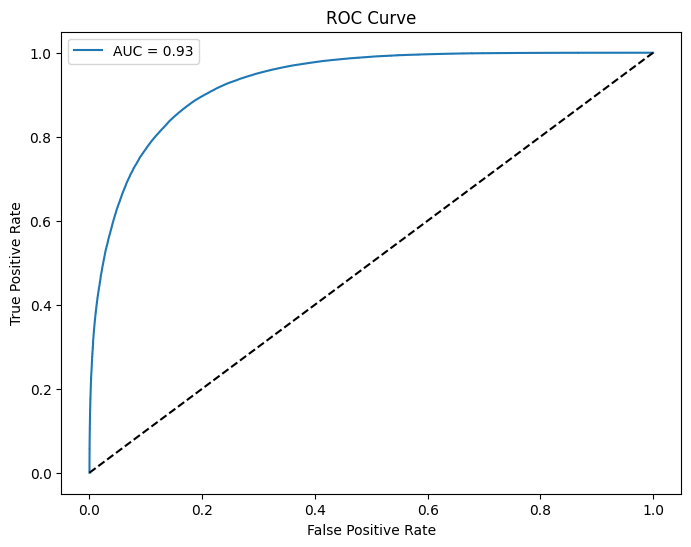

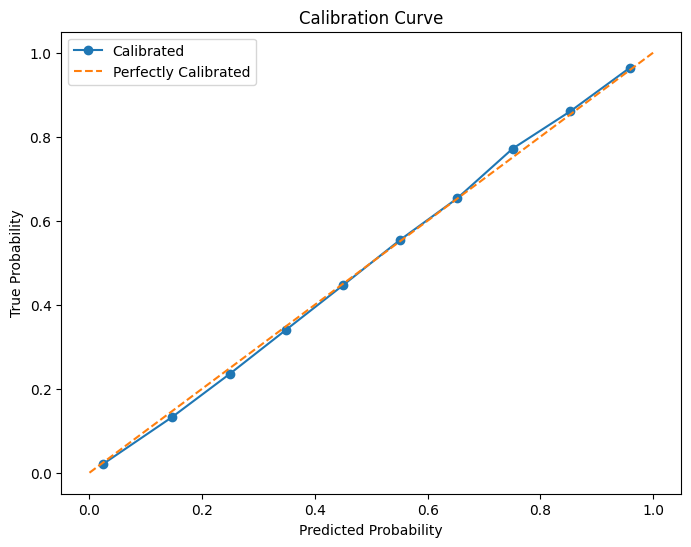

Brier Score: 0.10593572770509332


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Brier Score
brier_score = brier_score_loss(y_test, y_pred_proba[:, 1])
print("Brier Score:", brier_score)

### Predicting Swing Probability for Year 3 <a id="toc2_5"></a>


In order to check how well the model performs in year 3, I will use the same features as in years 1 and 2 to predict the probability of a swing in year 3. Then, I will plot the percentage of times that the probability was correct, if the probability was higher than 50% and the player swung, or if the probability was lower than 50% and the player did not swing.


In [ ]:
# new year_3 which is just a copy of the original
new_year_3 = data_2024.copy()

#calculate probability prediction to df_year_3
new_year_3 = pd.get_dummies(data_2024, columns=string_cols)

#prepare dataset for prediction 
new_year_3_pred = new_year_3.reindex(columns=trained_columns, fill_value=0)

#delete swing column
new_year_3_pred = new_year_3_pred.drop(columns=['swing'])

#Adding the predicted probabilities using the calibrated_lgbm model
new_year_3_pred['probability'] = calibrated_lgbm.predict_proba(new_year_3_pred)[:, 1]

#Adding the predicted probabilities to the dataframe
#The rows should be in the same order
data_2024['SwingProbability'] = new_year_3_pred['probability']


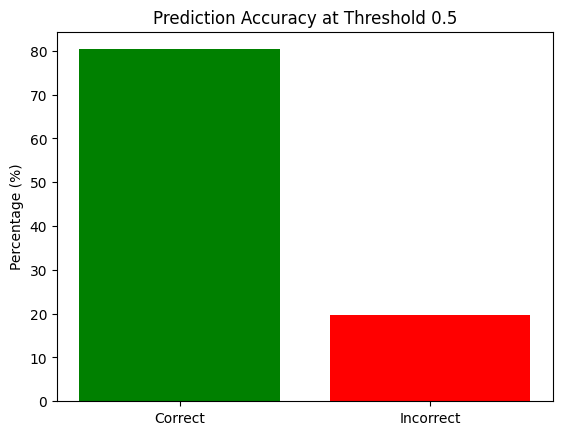

In [ ]:
# Plot accuracy of the swing probability and actual swings
# Define "correct" predictions based on threshold 0.5
data_2024['CorrectPrediction'] = ((data_2024['swing'] == 1) & (data_2024['SwingProbability'] > 0.5)) | \
                          ((data_2024['swing'] == 0) & (data_2024['SwingProbability'] <= 0.5))

# Calculate percentages
percent_correct = data_2024['CorrectPrediction'].mean() * 100
percent_incorrect = 100 - percent_correct

# Plot
plt.bar(['Correct', 'Incorrect'], [percent_correct, percent_incorrect], color=['green', 'red'])
plt.ylabel('Percentage (%)')
plt.title('Prediction Accuracy at Threshold 0.5')
plt.show()

The model predicted correctly about 80% of the times, which is consistent with the accuracy obtained in years 1 and 2. Certainly, this is an initial exploratory model, and further improvements can be made to increase the accuracy, such as bringing more features, using higher order metrics, or combining models.

## Feature Exploration <a id="toc3"></a>

In the following sections I will explore how features relate to swing probabilities for middle-middle pitches. Those are the tricky ones. 
<br>In order to explore those features, I will use only a small subset of year_3 dataset that includes only middle-middle pitches. Next, I will use that subset to generate predictions using the model previously created. Finally, based on those predictions I will use the module shap to explore how the features affected the model's decisions.

In [ ]:
data_2024 = data_2024[data_2022.columns]

# Calculate center of strike zone
data_2024['center_strike_zone'] = (data_2024['sz_top'] - data_2024['sz_bot']) / 2 + data_2024['sz_bot']

# Filter for middle-middle pitches
mid_mid_df = data_2024[
    (data_2024['plate_x'].abs() < 0.5) &
    ((data_2024['plate_z'] - data_2024['center_strike_zone']).abs() < 0.50)
]

mid_mid_df.dropna() #dropping nans to avoid errors

#transforming categorical variables into dummies, similarly to the training set
mid_mid_df = pd.get_dummies(mid_mid_df, columns=['stand', 'p_throws', 'pitch_type'],dtype=int)
#Remove the variables that are not needed
Xmid = mid_mid_df.drop(columns=['center_strike_zone','Unnamed: 0'])
expected_features = lgbm.booster_.feature_name()

# Add missing columns with default value 0 because some features are not present
#in the 2024 dataset
for col in expected_features:
    if col not in Xmid.columns:
        Xmid[col] = 0

# Reorder columns to match the model
Xmid = Xmid[expected_features]



In [ ]:
#Selecting only a small subset of data to speed up the process
select = range(10000)
Xmid = Xmid.iloc[select]

# Create a SHAP explainer
explainer = shap.TreeExplainer(lgbm)
expected_value = explainer.expected_value
shap_values = explainer(Xmid)

## How to read Shap plots
SHAP (SHapley Additive exPlanations) is a method used to explain the output of machine learning models. It assigns each feature an importance value for a particular prediction. The SHAP values indicate how much each feature contributes to the difference between the actual prediction and the average prediction.
<br><br> Below you can find a Beeswarm plot. Each point on the plot represents a SHAP value for a feature and an instance (a specific prediction). The position on the x-axis shows the impact of that feature on the model's output. Points to the right indicate a positive impact (increasing the swing probability), while points to the left indicate a negative impact (decreasing the swing probability). The color of the points represents the feature value (red for high values, blue for low values). When dots stack vertically, it indicates that multiple instances have similar SHAP values for that feature.

Take some time to observe the plots below and interpret them. I will discuss the most significant features after the plot.

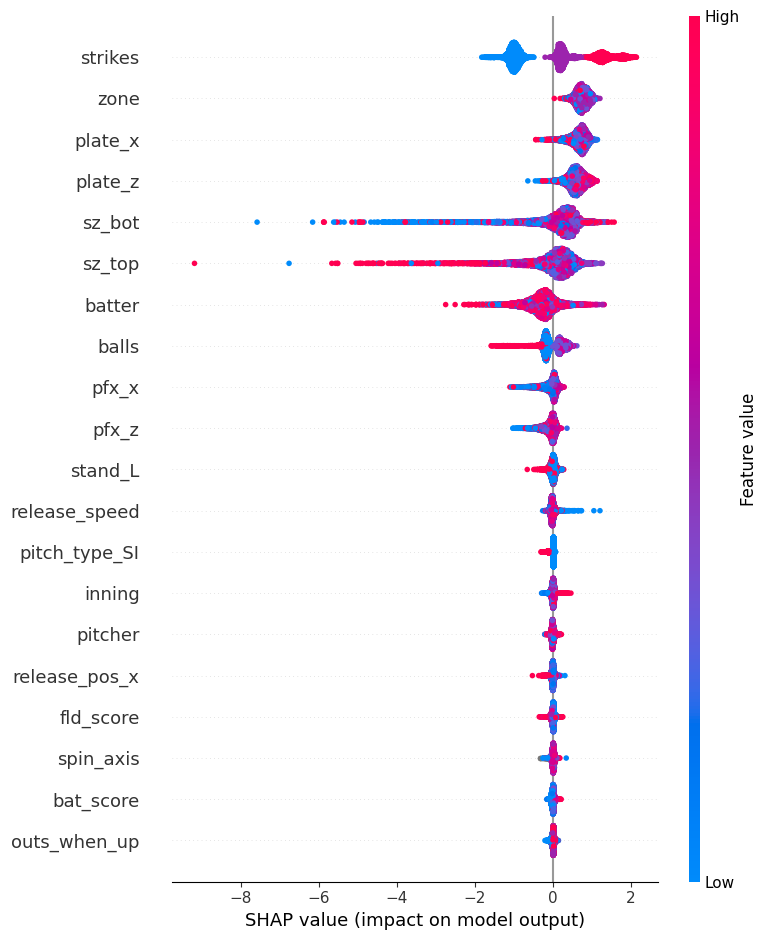

In [ ]:
shap.summary_plot(shap_values,Xmid)

When analyzing SHAP plots, we look for patterns that reveal how features influence predictions. For example, the feature "strikes" shows a clear trend: fewer strikes (blue points) are associated with a lower probability of a swing, while more strikes (red points) increase that probability.
Another notable feature is release speed. Slower pitches (blue dots) tend to increase the likelihood of a swing, as most blue dots appear on the right side of the plot—indicating higher swing probabilities.
The most dispersed features are sz_bot and sz_top, which represent the bottom and top boundaries of the strike zone. High values for the top zone (red dots) and low values for the bottom zone (blue dots) are both linked to a decreased probability of a swing.
An additional interesting feature is the pitch type "SI". When this pitch type is used (red dots), it tends to reduce the probability of a swing.


## Shap Dependence Plots

Next I will use dependence plots to further explore how specific features affect the model's predictions. <br><br>On the x-axis, you can see the actual values of the feature. On the y-axis, you see the SHAP values, which tell you how much that feature pushes the prediction up or down.
Each dot represents one data point. The color of the dots shows the value of another feature, helping you spot interactions between features.
For example, if you plot “release_speed” and color by “plate_z,” you can see how pitch speed affects swing probability, and how that effect changes depending on pitch height.
If the dots go upward as the feature increases, it means higher values push the prediction higher. If they go downward, higher values reduce the prediction.
These plots help understanding not just which features matter, but how they behave and interact in your model.<br><br>Below, I decided to strikes vs. balls and release speed vs. plate_z. For strikes and balls the result should be obvious, but it is interesting to check whether the model captured that. For release speed and plate_z, it would be useful for the coaches to know whether faster or slower pitches are more likely to induce swings at different heights. This information can be really useful for pitchers and coaches when planning their pitching strategies against specific batters.




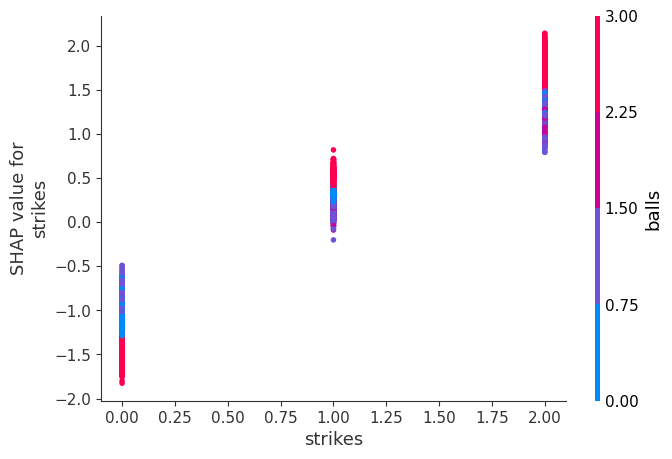

In [ ]:
#dependence plots
shap.dependence_plot("strikes", shap_values.values, Xmid, interaction_index="balls")


For balls and strikes the result is as expected. The more strikes the batter has, the more likely he is to swing. But notice how the ball pattern is interesting. The amount of balls a player has differently impacts swing probability depending on the amount of strikes. <br>At 0 strikes, swing probability is suppressed.
<br>At 1 strike, swing probability is moderate.
<br>At 2 strikes, swing probability is strongly boosted.
The number of balls fine-tunes this effect: more balls generally increase swing probability, especially with 2 strikes. However, with 0 strikes, more balls actually decrease swing probability. This shows how the count context (balls and strikes) jointly influences a batter's decision to swing. 

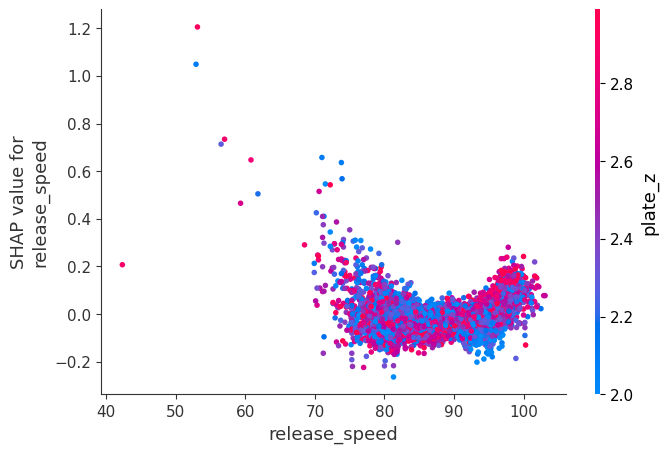

In [ ]:
shap.dependence_plot("release_speed", shap_values.values, Xmid, interaction_index="plate_z")

For release speed vs. plate_z, the first interesting pattern is this U shape of the dots. This indicates that the relationship between release speed and swing probability is not linear. In general, after 90mph, increasing velocity does not significantly increase swing probability. However, at lower velocities, increasing speed does increase swing probability. The position on the plate seems to have a minor effect.  